In [21]:
import warnings

import acnportal.signals.tariffs

warnings.simplefilter(action='ignore')

import pytz
from datetime import datetime
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from acnportal import acnsim
from acnportal import algorithms
from acnportal import signals

In [2]:
# Timezone of the ACN we are using.
timezone = pytz.timezone('America/Los_Angeles')

# Start and End times are used when collecting data.
start = timezone.localize(datetime(2019, 5, 1))
end = timezone.localize(datetime(2019, 7, 1))

# How long each time discrete time interval in the simulation should be.
period = 5  # minutes

# Voltage of the network.
voltage = 220  # volts

# Default maximum charging rate for each EV battery.
default_battery_power = 32 * voltage / 1000 # kW

# Identifier of the site where data will be gathered.
ct_site = 'caltech'
jpl_site = 'jpl'
of_site = 'office001'

# API Key for Grabbing Event Data
API_KEY = 'ESbDF9p6RSql-o20gIg5c7A9BSWQVwclv6pJAEAQrNE'

In [3]:
# create network objects for each site
cn = acnsim.sites.caltech_acn(basic_evse=True, voltage=voltage)
jn = acnsim.sites.jpl_acn(basic_evse=True, voltage=voltage)
on = acnsim.sites.office001_acn(basic_evse=True, voltage=voltage)

/Applications/anaconda3/envs/tf/lib/python3.10/site-packages/acnportal/acnsim/network/current.py:33: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  super().__init__({load_id: 1 for load_id in loads})


In [4]:
# generate events for each site
ct_events = acnsim.acndata_events.generate_events(API_KEY, ct_site, start, end, period, voltage, default_battery_power)
jpl_events = acnsim.acndata_events.generate_events(API_KEY, jpl_site, start, end, period, voltage, default_battery_power)
of_events = acnsim.acndata_events.generate_events(API_KEY, of_site, start, end, period, voltage, default_battery_power)

In [5]:
# set a scheduling algorithm
algorithm = algorithms.UncontrolledCharging()

In [6]:
# create and run a simulation object for each site
ct_sim = acnsim.Simulator(deepcopy(cn), algorithm, deepcopy(ct_events), start, period=period, verbose=False)
ct_sim.run()

/Applications/anaconda3/envs/tf/lib/python3.10/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 107. Max violation is 15.999989999999997 A on AV Pod at time index 0.
  warnings.warn(
/Applications/anaconda3/envs/tf/lib/python3.10/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 108. Max violation is 47.99999 A on AV Pod at time index 0.
  warnings.warn(
/Applications/anaconda3/envs/tf/lib/python3.10/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 109. Max violation is 47.99999 A on AV Pod at time index 0.
  warnings.warn(
/Applications/anaconda3/envs/tf/lib/python3.10/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 110. Max violation is 47.99999 A on AV Pod at time index 0.
  warnings.warn(
/Applications/anaconda3/envs/tf/lib/python3.10/site-packages/acnportal/acnsim/simulator.py

In [7]:
jn_sim = acnsim.Simulator(deepcopy(jn), algorithm, deepcopy(jpl_events), start, period=period, verbose=False)
jn_sim.run()

/Applications/anaconda3/envs/tf/lib/python3.10/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 70. Max violation is 21.6424122385869 A on First Floor Transformer Secondary A at time index 0.
  warnings.warn(
/Applications/anaconda3/envs/tf/lib/python3.10/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 71. Max violation is 44.3280739081338 A on First Floor Transformer Secondary C at time index 0.
  warnings.warn(
/Applications/anaconda3/envs/tf/lib/python3.10/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 72. Max violation is 44.3280739081338 A on First Floor Transformer Secondary C at time index 0.
  warnings.warn(
/Applications/anaconda3/envs/tf/lib/python3.10/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 73. Max violation is 44.3280739081338 A on First Floor Transformer Se

In [8]:
on_sim = acnsim.Simulator(deepcopy(on), algorithm, deepcopy(of_events), start, period=period, verbose=False)
on_sim.run()

# Aggregate Current

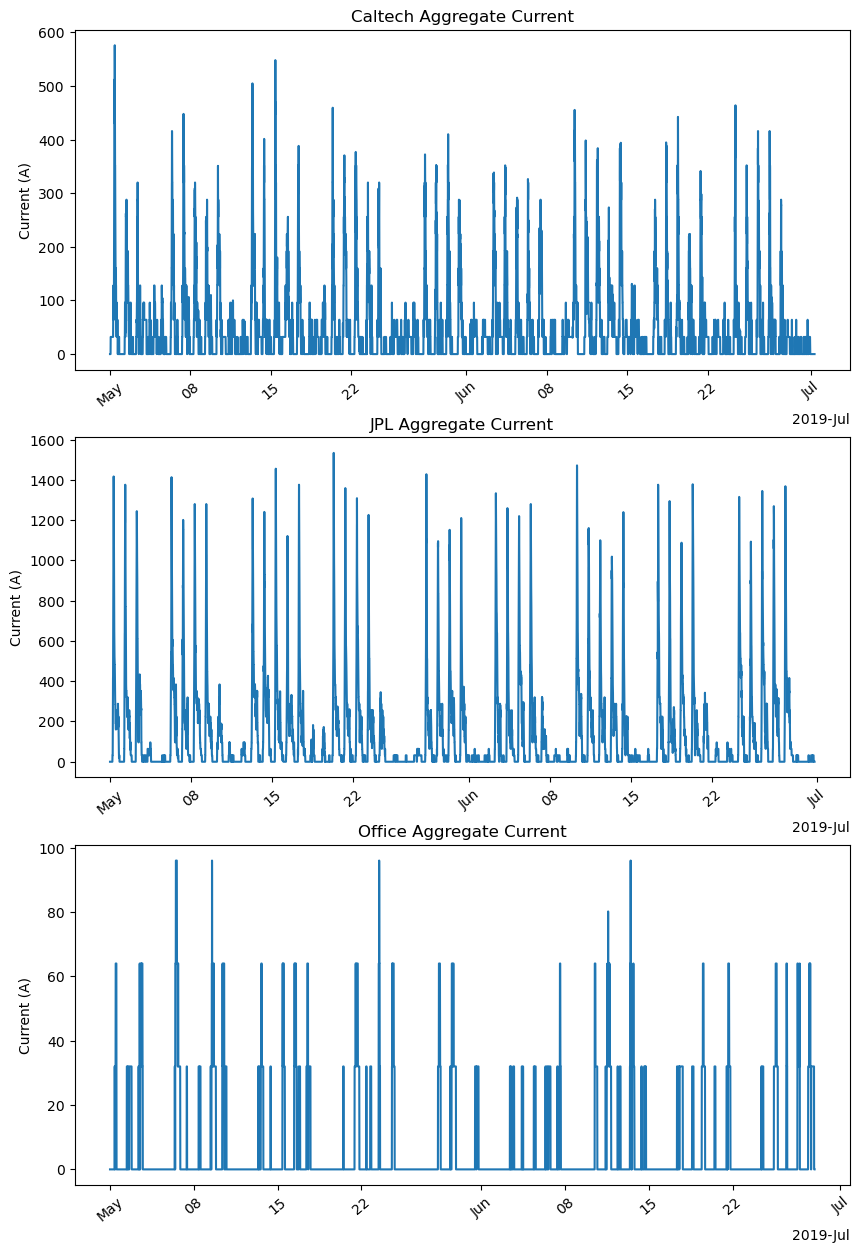

In [9]:
# plot the results for each site
sim_dates = mdates.date2num(acnsim.datetimes_array(ct_sim))
sim2_dates = mdates.date2num(acnsim.datetimes_array(jn_sim))
sim3_dates = mdates.date2num(acnsim.datetimes_array(on_sim))

# Set locator and formatter for datetimes on x-axis.
locator = mdates.AutoDateLocator(maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
agg_current_ct = acnsim.aggregate_current(ct_sim)
agg_current_jn = acnsim.aggregate_current(jn_sim)
agg_current_on = acnsim.aggregate_current(on_sim)

ax[0].plot(sim_dates, agg_current_ct, label='Caltech')
ax[1].plot(sim2_dates, agg_current_jn, label='JPL')
ax[2].plot(sim3_dates, agg_current_on, label='Office')

ax[0].set_title('Caltech Aggregate Current')
ax[1].set_title('JPL Aggregate Current')
ax[2].set_title('Office Aggregate Current')

for a in ax:
    a.set_ylabel('Current (A)')
    for label in a.get_xticklabels():
        label.set_rotation(40)
    a.xaxis.set_major_locator(locator)
    a.xaxis.set_major_formatter(formatter)
plt.savefig('agg_current.png', bbox_inches='tight')
plt.show()

In [28]:
print("Proportion of requested\nenergy delivered:")
total_energy_prop_ct = acnsim.proportion_of_energy_delivered(ct_sim)
print('Caltech: {0:.6f}'.format(total_energy_prop_ct))
total_energy_prop_jn = acnsim.proportion_of_energy_delivered(jn_sim)
print('JPL: {0:.6f}'.format(total_energy_prop_jn))
total_energy_prop_on = acnsim.proportion_of_energy_delivered(on_sim)
print('Office: {0:.6f}'.format(total_energy_prop_on))

Proportion of requested
energy delivered:
Caltech: 0.999948
JPL: 1.000000
Office: 0.999995


In [17]:
print("Peak aggregate current")
print('Caltech: {0:.3f} A'.format(ct_sim.peak))
print('JPL: {0:.3f} A'.format(jn_sim.peak))
print('Office: {0:.3f} A'.format(on_sim.peak))

Peak aggregate current
Caltech: 576.000 A
JPL: 1534.055 A
Office: 96.000 A


# Cost

In [24]:
tarrif = signals.tariffs.TimeOfUseTariff("sce_tou_ev_8_june_2019")
print("Energy cost: ")
ct_cost = acnsim.energy_cost(ct_sim, tarrif)
print('Caltech: ${0:.2f}'.format(ct_cost))
jn_cost = acnsim.energy_cost(jn_sim, tarrif)
print('JPL: ${0:.2f}'.format(jn_cost))
on_cost = acnsim.energy_cost(on_sim, tarrif)
print('Office: ${0:.2f}'.format(on_cost))

Energy cost: 
Caltech: $2100.05
JPL: $5877.60
Office: $346.21
